In [50]:
# Step 1

import pandas as pd
import numpy as np
from gurobipy import Model, GRB, quicksum

df = pd.read_csv("/Users/roblegure/Downloads/data.csv")

# Extracting name column into a list
I = df["name"].tolist()

# Time slots with slot size 0.5 representing 30 minutes
slot_size = 0.5
T = np.arange(0, 24 + slot_size, slot_size).tolist()

start_time = {}
end_time = {}
for _, row in df.iterrows():
    name = row["name"]
    start_time[name] = row["start_time"]
    end_time[name] = row["end_time"]

# Availability map: 1 if time slot is inside their window, else 0
availability = {i: {} for i in I}
for _, row in df.iterrows():
    name = row["name"]
    start = row["start_time"]
    end = row["end_time"]
    for t in T:
        availability[name][t] = 1 if start <= t <= end else 0

# Washer and dryer names used for the model
washers = ["W1", "W2"]
dryers = ["D1", "D2"]

In [51]:
# Step 2

# Initialize a Gurobi model which will contain everything
m = Model("LaundryScheduling")

In [52]:
# Step 3 (Decision variables)

# W[i, j, t] = 1  -> student i is assigned to wash on machine j at time t
# W[i, j, t] = 0  -> otherwise
# Goal is to loop over all of the students, washing machines, and time slots and create every possible choice so that the optimizer
# can choose the best combo for each student 
W = {}
for i in I:
    for j in washers:
        for t in T:
            W[i,j,t] = m.addVar(vtype=GRB.BINARY, name=f"W[{i},{j},{t}]")

# D[i, j, t] = 1  -> student i is assigned to use dryer j at time t
# D[i, j, t] = 0  -> otherwise
# Goal is to loop over all of the students, dryers, and time slots and create every possible choice so that the optimizer
# can choose the best combo for each student 
D = {}
for i in I:
    for j in dryers:
        for t in T:
            D[i,j,t] = m.addVar(vtype=GRB.BINARY, name=f"D[{i},{j},{t}]")

# Delay variables
delay_before = {}
delay_between = {}
delay_after = {}
total_delay = {}

for i in I:
    delay_before[i] = m.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"DelayBefore[{i}]")
    delay_between[i] = m.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"DelayBetween[{i}]")
    delay_after[i] = m.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"DelayAfter[{i}]")
    total_delay[i] = m.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"TotalDelay[{i}]")

# Max delay makes sure that the schedule enforces the fairness by reducing the largest delay
D_max = m.addVar(vtype=GRB.CONTINUOUS, name="D_max")

In [53]:
# Step 4 (Assigned Times)

# Assigned wash and dry times for each student
wash_start = {}
dry_start = {}

for i in I:
    wash_start[i] = quicksum(
        t * W[i, j, t]
        for j in washers
        for t in T[:-1]
        if (i, j, t) in W
    )

    dry_start[i] = quicksum(
        t * D[i, j, t]
        for j in dryers
        for t in T[:-1]
        if (i, j, t) in D
    )

In [54]:
# Step 5 (Constraints)

# Each student gets exactly 1 wash and 1 dry slot
for i in I:
    m.addConstr(quicksum(W[i,j,t] for j in washers for t in T[:-1]) == 1,
                name=f"OneWash[{i}]")
    m.addConstr(quicksum(D[i,j,t] for j in dryers  for t in T[:-1]) == 1,
                name=f"OneDry[{i}]")

# At most one student can use a washer and dryer at the same time
for j in washers:
    for t in T[:-1]:
        m.addConstr(quicksum(W[i,j,t] for i in I) <= 1)

for j in dryers:
    for t in T[:-1]:
        m.addConstr(quicksum(D[i,j,t] for i in I) <= 1)

# If a student isn't available at t (time) then the cannot wash or dry at t
for i in I:
    for t in T[:-1]:
        if not (availability[i][t] == 1 and availability[i][t+0.5] == 1):
            m.addConstr(quicksum(W[i,j,t] for j in washers) == 0)
            m.addConstr(quicksum(D[i,j,t] for j in dryers) == 0)

# Drying must occur after washing
for i in I:
    m.addConstr(dry_start[i] >= wash_start[i] + 1.0,
                name=f"DryAfterWash[{i}]")
    m.addConstr(dry_start[i] <= wash_start[i] + 1.5,
                name=f"DryWithin30Minutes[{i}]")

# A student cannot wash and dry at the same time slot
for i in I:
    m.addConstr(dry_start[i] >= wash_start[i] + 1.0,  # wash ends before dry begins
                name=f"DryAfterWash[{i}]")
    m.addConstr(dry_start[i] <= wash_start[i] + 1.5,  # within 30 mins of finish
                name=f"DryWithin30[{i}]")

for i in I:
    for t in T:
        for j_w in washers:
            for j_d in dryers:
                m.addConstr(D[i,j_d,t] + W[i,j_w,t] <= 1)


for i in I:
    # how long before they start washing
    m.addConstr(delay_before[i] >= wash_start[i] - start_time[i])

    # wet clothes waiting between wash and dry
    m.addConstr(delay_between[i] >= dry_start[i] - (wash_start[i] + 1.0))

    m.addConstr(total_delay[i] == delay_before[i] + delay_between[i])
    m.addConstr(D_max >= total_delay[i]) 

In [55]:
# Step 6 (Objective function)

m.setObjective(
    D_max + quicksum(total_delay[i] for i in I),
    GRB.MINIMIZE
)


# Step 7 (Gurobi solver)

m.optimize()


# Step 8 (Print schedule)

if m.status == GRB.OPTIMAL:
    print("\nLaundry Schedule:")
    print("Student | WashMachine | WashStart | DryMachine | DryStart | Delay")
    print("--------+-------------+----------+------------+----------+-------")

    for i in I:
        wash_assign = [(j, t) for j in washers for t in T[:-1] if W[i, j, t].X > 0.5]
        dry_assign  = [(j, t) for j in dryers  for t in T[:-1] if D[i, j, t].X > 0.5]

        wash_assign = sorted(wash_assign, key=lambda x: x[1])
        dry_assign  = sorted(dry_assign, key=lambda x: x[1])

        if wash_assign:
            w_j, w_t = wash_assign[0]
        else:
            w_j, w_t = None, None

        if dry_assign:
            d_j, d_t = dry_assign[0]
        else:
            d_j, d_t = None, None

        print(f"{i:8} | {w_j:11} | {w_t:8} | {d_j:10} | {d_t:8} | {total_delay[i].X:5.2f}")

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 14702 rows, 11001 columns and 106295 nonzeros
Model fingerprint: 0xb45a2c7c
Variable types: 221 continuous, 10780 integer (10780 binary)
Coefficient statistics:
  Matrix range     [5e-01, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 2e+01]
Presolve removed 13351 rows and 7124 columns
Presolve time: 0.06s
Presolved: 1351 rows, 3877 columns, 22638 nonzeros
Variable types: 107 continuous, 3770 integer (3760 binary)
Found heuristic solution: objective 106.5000000

Root relaxation: objective 4.965517e+01, 818 iterations, 0.01 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   49.65517    0  173 

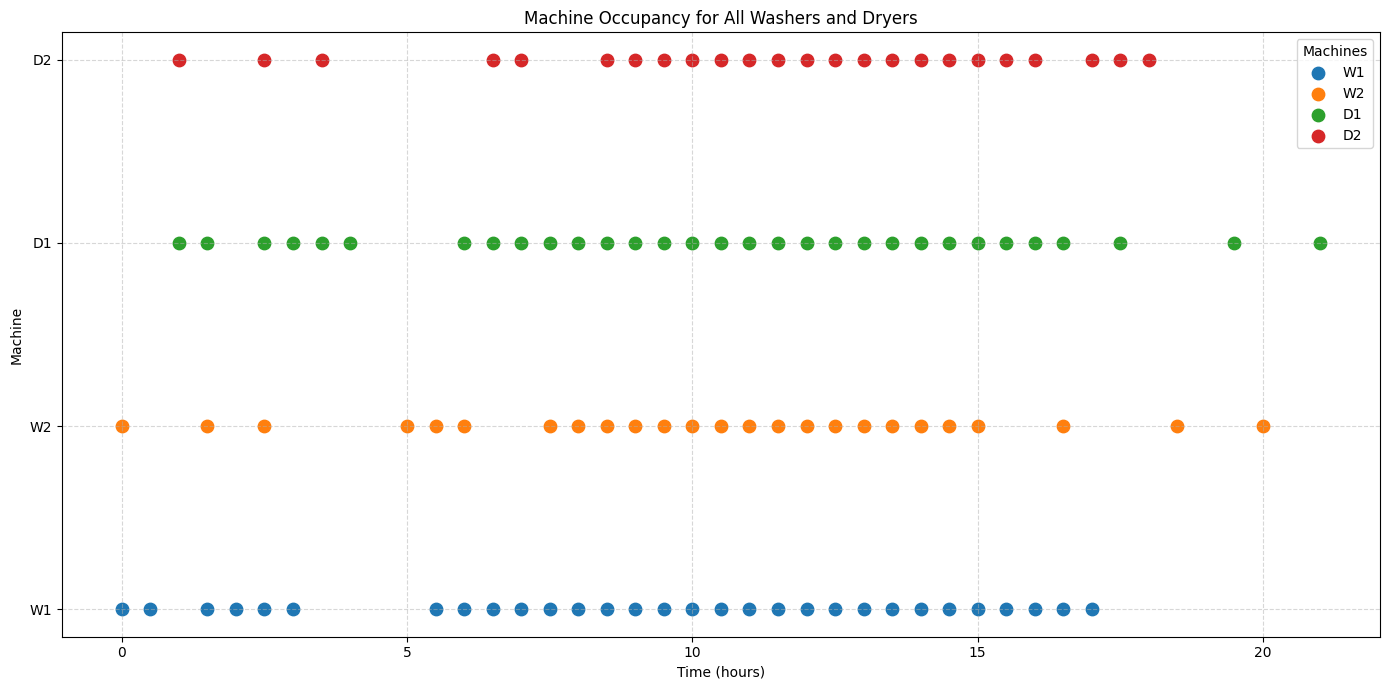

In [56]:
import matplotlib.pyplot as plt
import pandas as pd

# Your solved schedule converted into DataFrame
data = [
    ("Luke","W2",1.5,"D2",2.5,0.00),
    ("Roble","W2",0.0,"D1",1.0,0.00),
    ("Kayla","W1",17.0,"D2",18.0,0.00),
    ("George","W2",11.5,"D2",12.5,0.00),
    ("Cleveland","W1",8.0,"D1",9.0,0.00),
    ("Cliff","W2",6.0,"D2",7.0,0.00),
    ("Clifford","W1",13.0,"D1",14.0,2.50),
    ("Clifton","W1",10.5,"D2",11.5,2.00),
    ("Clint","W2",20.0,"D1",21.0,0.00),
    ("Clinten","W1",8.5,"D2",9.5,0.00),
    ("Clinton","W1",14.0,"D1",15.0,2.50),
    ("Clive","W2",9.0,"D2",10.0,0.00),
    ("Clyde","W1",3.0,"D1",4.0,0.00),
    ("Cob","W1",16.0,"D2",17.0,0.00),
    ("Cobb","W2",13.0,"D2",14.0,3.00),
    ("Cobbie","W2",10.0,"D1",11.0,0.00),
    ("Cobby","W2",12.5,"D1",13.5,3.00),
    ("Cody","W1",0.5,"D1",1.5,0.00),
    ("Colbert","W2",16.5,"D2",17.5,0.00),
    ("Cole","W2",5.0,"D1",6.0,0.00),
    ("Coleman","W1",7.5,"D2",8.5,0.00),
    ("Colin","W1",11.0,"D1",12.0,0.50),
    ("Collin","W2",15.0,"D2",16.0,2.50),
    ("Collins","W1",9.0,"D1",10.0,0.50),
    ("Conan","W1",14.5,"D1",15.5,3.00),
    ("Connie","W1",6.0,"D1",7.0,0.00),
    ("Connolly","W2",7.5,"D1",8.5,0.00),
    ("Connor","W1",7.0,"D1",8.0,0.00),
    ("Conrad","W2",10.5,"D1",11.5,1.50),
    ("Conroy","W2",13.5,"D2",14.5,3.00),
    ("Constantin","W1",11.5,"D1",12.5,1.00),
    ("Constantine","W1",12.5,"D2",13.5,3.00),
    ("Holly","W1",0.0,"D2",1.0,0.00),
    ("Holly-Anne","W2",9.5,"D1",10.5,0.50),
    ("Hollyanne","W1",12.0,"D1",13.0,1.50),
    ("Honey","W2",5.5,"D1",6.5,0.00),
    ("Honor","W1",16.5,"D1",17.5,0.00),
    ("Honoria","W1",2.0,"D1",3.0,0.00),
    ("Hope","W2",12.0,"D2",13.0,2.50),
    ("Horatia","W1",9.5,"D2",10.5,0.00),
    ("Hortense","W2",14.0,"D2",15.0,3.00),
    ("Hortensia","W2",11.0,"D2",12.0,0.00),
    ("Hulda","W2",18.5,"D1",19.5,0.00),
    ("Hyacinth","W1",6.5,"D1",7.5,0.00),
    ("Hyacintha","W1",1.5,"D1",2.5,0.00),
    ("Hyacinthe","W1",5.5,"D2",6.5,0.00),
    ("Hyacinthia","W2",2.5,"D1",3.5,0.00),
    ("Hyacinthie","W2",8.5,"D1",9.5,0.00),
    ("Hynda","W2",14.5,"D2",15.5,3.00),
    ("Ianthe","W2",8.0,"D2",9.0,0.00),
    ("Ibbie","W1",10.0,"D2",11.0,0.00),
    ("Ibby","W1",2.5,"D2",3.5,0.00),
    ("Ida","W1",15.5,"D1",16.5,3.00),
    ("Idalia","W1",15.0,"D1",16.0,3.50),
    ("Idalina","W1",13.5,"D1",14.5,3.00),
]

df = pd.DataFrame(data, columns=[
    "Student","WashMachine","WashTime","DryMachine","DryTime","Delay"
])

washers = ["W1","W2"]
dryers = ["D1","D2"]
machine_data = {}

for machine in washers + dryers:
    if machine.startswith("W"):
        times = df[df["WashMachine"] == machine]["WashTime"]
    else:
        times = df[df["DryMachine"] == machine]["DryTime"]
    machine_data[machine] = times.tolist()

plt.figure(figsize=(14,7))

for machine, times in machine_data.items():
    plt.scatter(times, [machine]*len(times), s=80, label=machine)

plt.xlabel("Time (hours)")
plt.ylabel("Machine")
plt.title("Machine Occupancy for All Washers and Dryers")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Machines")
plt.tight_layout()
